In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import plotly.express as px

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/soccer-players-values-and-their-statistics/transfermarkt_fbref_201819.csv
/kaggle/input/soccer-players-values-and-their-statistics/transfermarkt_fbref_201718.csv
/kaggle/input/soccer-players-values-and-their-statistics/transfermarkt_fbref_201920.csv


# 0. Data load

In [2]:
dfs = []

for filename in filenames:
    data = pd.read_csv('../input/soccer-players-values-and-their-statistics/'+filename, delimiter=';')
    dfs.append(data)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (395) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df = pd.concat(dfs)
df.drop(columns=['Column1', 'Unnamed: 0'], inplace=True)

# 1. Overview

In [4]:
df.head()

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
0,Borja Bastón,es ESP,FW,Alavés,25.0,1992.0,2000000.0,186.0,Forward - Centre-Forward,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0.0,201819#
1,Burgui,es ESP,"MF,FW",Alavés,24.0,1993.0,1500000.0,184.0,Forward - Left Winger,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0.0,201819#
2,Jonathan Calleri,ar ARG,FW,Alavés,24.0,1993.0,9000000.0,181.0,Forward - Centre-Forward,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0.0,201819#
3,Rubén Duarte,es ESP,DF,Alavés,22.0,1995.0,5000000.0,172.0,Defender - Left-Back,left,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0.0,201819#
4,Rodrigo Ely,br BRA,DF,Alavés,24.0,1993.0,2000000.0,188.0,Defender - Centre-Back,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0.0,201819#


In [5]:
df.shape

(7108, 399)

In [6]:
df.isna().mean().mean()

0.027195168562938125

# 2. Hypothesis: Diferent features are more important for each position

In [7]:
df['position'].value_counts()

DF       2090
MF       1421
FW        910
FW,MF     786
MF,FW     669
GK        528
DF,MF     315
MF,DF     153
DF,FW      56
FW,DF      46
GK,MF       1
0           1
Name: position, dtype: int64

In [8]:
df['position'].str[:2].value_counts()

DF    2461
MF    2243
FW    1742
GK     529
0        1
Name: position, dtype: int64

In [9]:
df = df[df['position']!='0']
df.dropna(subset=['position'], inplace=True)
df['main_position'] = df['position'].str[:2]
df['main_position'].value_counts()

DF    2461
MF    2243
FW    1742
GK     529
Name: main_position, dtype: int64

In [10]:
# testing generic feature
df_for_position = [df[df['main_position']==pos] for pos in df['main_position'].unique()]
len(df_for_position)

4

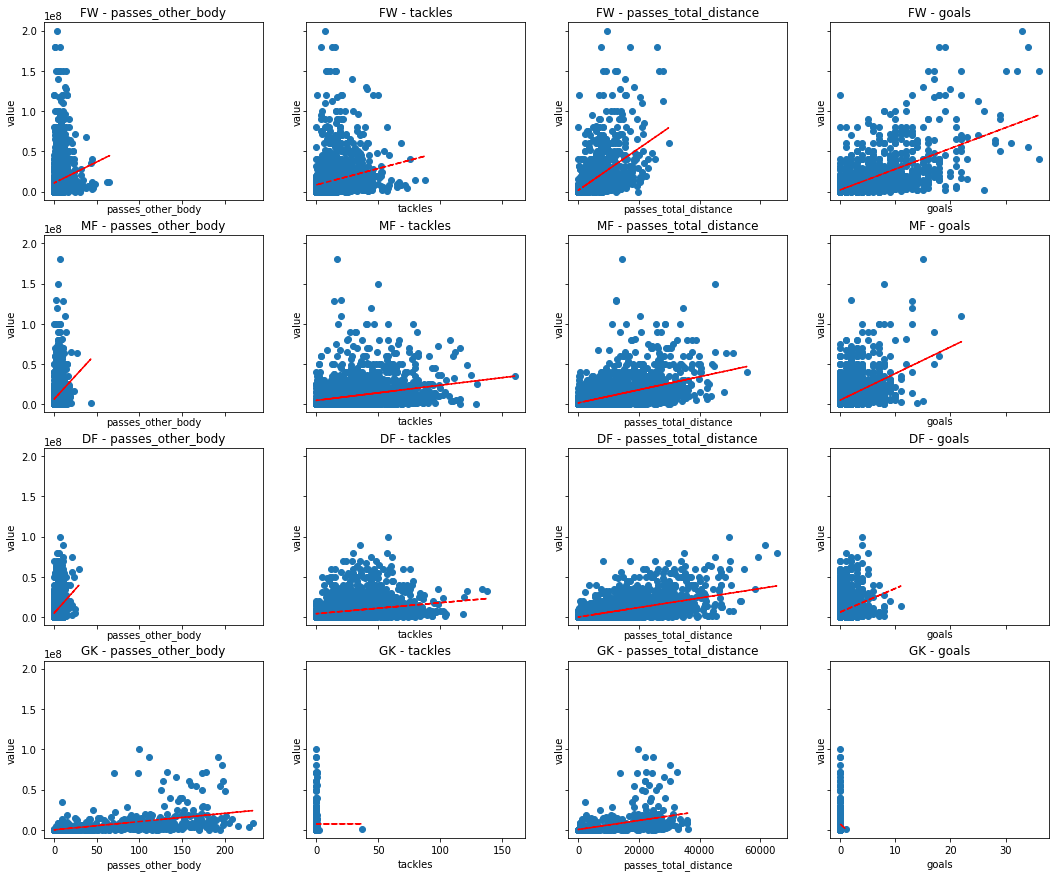

In [11]:
# testing for generic feature

features = ['passes_other_body', 'tackles', 'passes_total_distance', 'goals']


# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(4, 4, figsize=(18,15), sharey='all', sharex='col')

features_i = 0
for feature in features:
    df_i = 0
    for df_pos in df_for_position:
        idx = (df_i, features_i)
        x = df_pos[feature]
        y = df_pos['value']
        axs[idx].scatter(x, y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        axs[idx].plot(x, p(x), "r--")
        
        axs[idx].set_title(df_pos['position'].min() + ' - ' + feature)
        axs[idx].set_ylabel('value')
        axs[idx].set_xlabel(feature)
        df_i += 1
    features_i += 1

plt.savefig('scatter_for_dif_pos.png')